# Модуль: Unsupervised Learning

<span style="font-size: 14pt">ФИВТ, АПТ, Курс по машинному обучению, Весна 2017, семинар 14 </span>

<span style="color:blue; font-size: 12pt">Alexey Romanenko, </span>
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

# Методы кластеризации
<h3> Plan </h3>

* ** Напоминание лекции ** 
 - Задача кластеризации
 - Демо k-means, DBSCAN
 - Обзор других методов кластеризации: AUTOENCODER


* **Реализация k-means**
 - Пример реализации k-means
 - Оптимизация начального расположения центров kmeans++
 
 
* **Кластеризация текстов**
 - Описание данных
 - Агломеративная кластеризация
 - k-means

In [1]:
import os
import time
import warnings
import datetime
import numpy as np
import pandas as pd
import random
from sklearn.metrics import accuracy_score as acc
from sklearn.model_selection import cross_val_score

import pylab

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


from IPython.display import Image, SVG

%matplotlib inline

<h1 align="center"> Напоминание лекции </h1>
** Вопросы **
* В чем суть задачи кластеризации?
* Как типы алгоритмов кластеризации вы знаете?
* Какие основные шаги выделяют в алгоритме k-means?
* Опишите кратко суть алгоритма DBSCAN.

## k-means demo
<a href='https://www.naftaliharris.com/blog/visualizing-k-means-clustering/'> k-means </a>

## DBSCAN demo
<a href='https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/'> DBSCAN </a>


---------
<h1 align="center"> Реализация k-means </h1>

In [26]:
class KMeans():
    def __init__(self, K, X=None, N=0):
        self.K = K
        if X == None:
            if N == 0:
                raise Exception("If no data is provided, \
                                 a parameter N (number of points) is needed")
            else:
                self.N = N
                self.X = self._init_board_gauss(N, K)
        else:
            self.X = X
            self.N = len(X)
        self.mu = None # a list of centers of clusters
        self.clusters = None # labels of samples
        self.method = None # method for sampling initial centers of clusters
 
    def _init_board_gauss(self, N, k):
        n = float(N)/k
        X = []
        for i in range(k):
            c = (random.uniform(-1,1), random.uniform(-1,1))
            s = random.uniform(0.05,0.15)
            x = []
            while len(x) < n:
                a,b = np.array([np.random.normal(c[0],s),np.random.normal(c[1],s)])
                # Continue drawing points from the distribution in the range [-1,1]
                if abs(a) and abs(b)<1:
                    x.append([a,b])
            X.extend(x)
        X = np.array(X)[:N]
        return X
 
    def plot_board(self, fig_size=(10,7) ):
        X = self.X
        fig = plt.figure(figsize = fig_size)
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        if self.mu and self.clusters:
            mu = self.mu
            clus = self.clusters
            K = self.K
            for m, clu in clus.items():
                cs = plt.cm.spectral(1.*m/self.K)
                plt.plot(mu[m][0], mu[m][1], 'o', marker='*', \
                         markersize=12, color=cs)
                plt.plot(zip(*clus[m])[0], zip(*clus[m])[1], '.', \
                         markersize=8, color=cs, alpha=0.5)
        else:
            plt.plot(zip(*X)[0], zip(*X)[1], '.', alpha=0.5)
        if self.method == '++':
            tit = 'K-means++'
        else:
            tit = 'K-means with random initialization'
        pars = 'N=%s, K=%s' % (str(self.N), str(self.K))
        plt.title('\n'.join([pars, tit]), fontsize=16)
        plt.savefig('kpp_N%s_K%s.png' % (str(self.N), str(self.K)), \
                    bbox_inches='tight', dpi=200)
 
    def _cluster_points(self):
        mu = self.mu
        clusters  = {}
        for x in self.X:
            # обновите привязку объектов к центрам кластеров (используйте np.linalg.norm )
            bestmukey = np.argmin([np.linalg.norm(x-cur) for cur in mu])
            try:
                clusters[bestmukey].append(x)
            except KeyError:
                clusters[bestmukey] = [x]
        self.clusters = clusters
 
    def _reevaluate_centers(self):
        clusters = self.clusters
        newmu = []
        keys = sorted(self.clusters.keys())
        for k in keys:
            newmu.append(np.mean(np.array(clusters[k]), axis=0))
        self.mu = newmu
 
    def _has_converged(self):
        K = len(self.oldmu)
        return(np.linalg.norm(np.array(self.oldmu) - np.array(self.mu)) <= 10**(-15) and len(set([tuple(a) for a in self.mu])) == K)
 
    def find_centers(self, method='random'):
        self.method = method
        X = self.X
        K = self.K
        self.oldmu = random.sample(X, K)
        if method != '++':
            # Initialize to K random centers
            self.mu = random.sample(X, K)
        while not self.oldmu or not self._has_converged():
            self.oldmu = self.mu#сохранить старые центры кластеров
            # Assign all points in X to clusters
            self._cluster_points()#обновите разметку кластеров
            # Reevaluate centers
            self._reevaluate_centers()#обновите центры кластеров


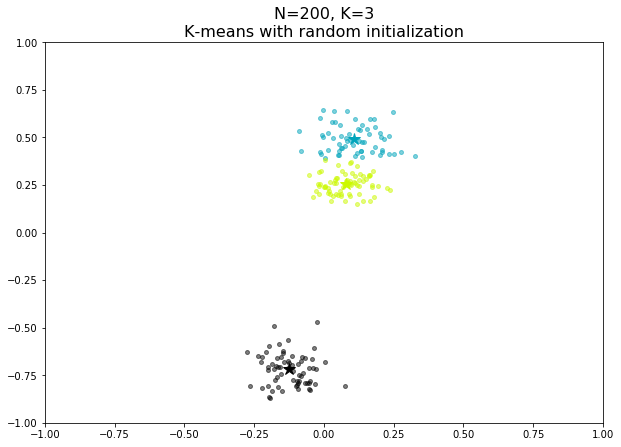

In [27]:
kmeans = KMeans(3, N=200)
kmeans.find_centers()
kmeans.plot_board(fig_size=(10,7))

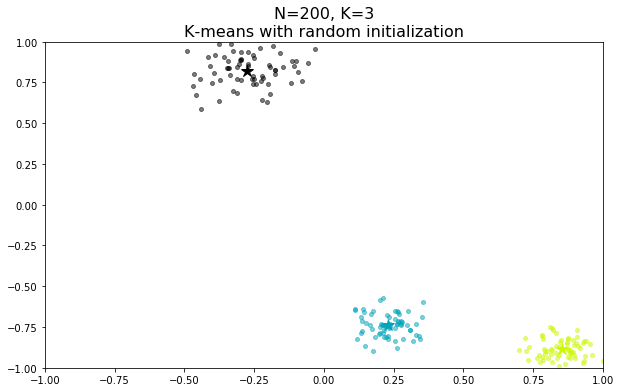

In [88]:
kmeans.find_centers()
kmeans.plot_board(fig_size=(10,6))

### Improve to Kmeans++

In [28]:
class KPlusPlus(KMeans):
    def _dist_from_centers(self):
        cent = self.mu
        X = self.X
        D2 = np.array([min([np.linalg.norm(x-c)**2 for c in cent]) for x in X])
        self.D2 = D2
 
    def _choose_next_center(self):
        self.probs = self.D2/self.D2.sum()
        self.cumprobs = self.probs.cumsum()
        r = random.random()
        ind = np.where(self.cumprobs >= r)[0][0]
        return(self.X[ind])
 
    def init_centers(self):
        self.mu = random.sample(self.X, 1)
        while len(self.mu) < self.K:
            self._dist_from_centers()
            self.mu.append(self._choose_next_center())
 
    def plot_init_centers(self, fig_size = (10,7)):
        X = self.X
        fig = plt.figure(figsize=(10,5))
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        plt.plot(zip(*X)[0], zip(*X)[1], '.', alpha=0.5)
        plt.plot(zip(*self.mu)[0], zip(*self.mu)[1], 'ro')
        plt.savefig('kpp_init_N%s_K%s.png' % (str(self.N),str(self.K)), \
                    bbox_inches='tight', dpi=200)

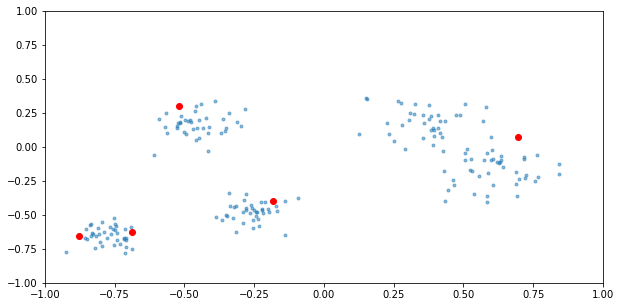

In [29]:
kplusplus = KPlusPlus(5, N=200)
kplusplus.init_centers()
kplusplus.plot_init_centers(fig_size=(10,5))

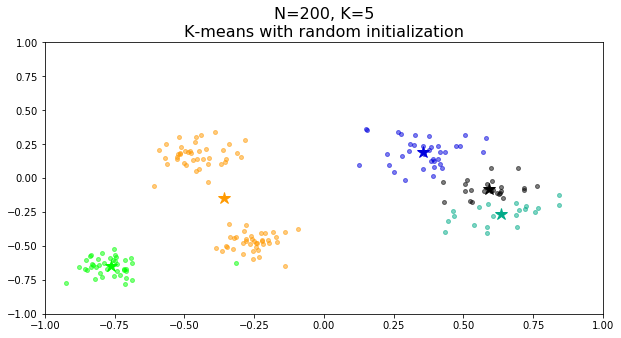

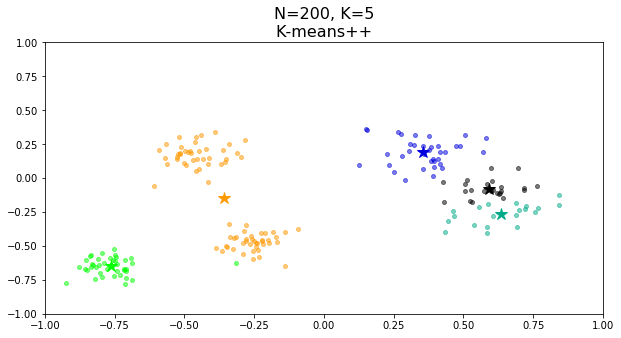

In [30]:
# Random initialization
kplusplus.find_centers(method='random')
kplusplus.plot_board(fig_size = (10,5))
# k-means++ initialization
kplusplus.find_centers(method='++')
kplusplus.plot_board(fig_size = (10,5))

-------
<h1 align="center">Кластеризация текстов</h1> 


##### Пример by V. Kantor
--------
** Вопросы:**
- В чём задача кластеризации текстов? 
- Что является объектами (samples), что такое признаки для этих ообъектов?

## Выборка

In [31]:
from sklearn.datasets import fetch_20newsgroups

In [32]:
train_all = fetch_20newsgroups(subset='train')
print (train_all.target_names)

No handlers could be found for logger "sklearn.datasets.twenty_newsgroups"


['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [33]:
simple_dataset = fetch_20newsgroups(
    subset='train', 
    categories=['comp.sys.mac.hardware', 'soc.religion.christian', 'rec.sport.hockey'])

In [34]:
print (simple_dataset.data[0])

From: erik@cheshire.oxy.edu (Erik Adams)
Subject: HELP!!  My Macintosh "luggable" has lines on its screen!
Organization: Occidental College, Los Angeles, CA 90041 USA.
Distribution: comp
Lines: 20

Okay, I don't use it very much, but I would like for it to keep working
correctly, at least as long as Apple continues to make System software
that will run on it, if slowly :-)

Here is the problem:  When the screen is tilted too far back, vertical
lines appear on the screen.  They are every 10 pixels or so, and seem
to be affected somewhat by opening windows and pulling down menus.
It looks to a semi-technical person like there is a loose connection
between the screen and the rest of the computer.

I am open to suggestions that do not involve buying a new computer,
or taking this one to the shop.  I would also like to not have
to buy one of Larry Pina's books.  I like Larry, but I'm not sure
I feel strongly enough about the computer to buy a service manual
for it.

On a related note:  what

In [35]:
print (simple_dataset.data[-1])

From: dlecoint@garnet.acns.fsu.edu (Darius_Lecointe)
Subject: Re: Sabbath Admissions 5of5
Organization: Florida State University
Lines: 21

I find it interesting that cls never answered any of the questions posed. 
Then he goes on the make statements which make me shudder.  He has
established a two-tiered God.  One set of rules for the Jews (his people)
and another set for the saved Gentiles (his people).  Why would God
discriminate?  Does the Jew who accepts Jesus now have to live under the
Gentile rules.

God has one set of rules for all his people.  Paul was never against the
law.  In fact he says repeatedly that faith establishes rather that annuls
the law.  Paul's point is germane to both Jews and Greeks.  The Law can
never be used as an instrument of salvation.  And please do not combine
the ceremonial and moral laws in one.

In Matt 5:14-19 Christ plainly says what He came to do and you say He was
only saying that for the Jews's benefit.  Your Christ must be a
politician, speaki

In [36]:
print (simple_dataset.data[-2])

From: scialdone@nssdca.gsfc.nasa.gov (John Scialdone)
Subject: CUT Vukota and Pilon!!!
News-Software: VAX/VMS VNEWS 1.41    
Organization: NASA - Goddard Space Flight Center
Lines: 32

I have been to all 3 Isles/Caps tilts at the Crap Centre this year, all Isles
wins and there is no justification for Vukota and Pilon to play for the Isles.
Vukota is absolutely the worst puck handler in the world!! He couldn't hit a
bull in the ass with a banjo!! Al must remember a few years back when Mick 
scored 3 goals in one period against the Caps in a 5-3 Isles win. I was there
and was astonished as was the rest of the crowd. Wake-up Al!!! Years later he's
gotten worse. He's a cheap shot artist and always ends up getting
stupid/senseless penalties. I think he would make a good police officier!!!

As for Pilon, he can't carry the puck out to center ice by himself. He either
makes a bad pass resulting in a turnover, or he attempts to bring the puck 
towards the neutral zone and skates right into an 

In [37]:
print (len(simple_dataset.data))

1777


### Признаки

In [38]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=500, min_df=10)
matrix = vectorizer.fit_transform(simple_dataset.data)
matrix.shape

(1777, 3767)

## Аггломеративная кластеризация (neighbour joining)

In [39]:
from sklearn.cluster.hierarchical import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=3, affinity='cosine', linkage='complete')
preds = model.fit_predict(matrix.toarray())

In [40]:
print(list(preds))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [41]:
print(matrix[0])

  (0, 1246)	0.390638938513
  (0, 239)	0.0950102887763
  (0, 1659)	0.0722667093676
  (0, 2082)	0.0965671776392
  (0, 1846)	0.0674142631248
  (0, 2991)	0.389561083053
  (0, 810)	0.0809427637022
  (0, 2056)	0.0961672074361
  (0, 319)	0.100549353806
  (0, 625)	0.0520717390913
  (0, 3553)	0.0734668995949
  (0, 1121)	0.0644281622922
  (0, 838)	0.101544778998
  (0, 69)	0.0685826705273
  (0, 2413)	0.102588780336
  (0, 3555)	0.0622908798771
  (0, 3600)	0.0573701527992
  (0, 2273)	0.0579600218377
  (0, 1905)	0.0817353647899
  (0, 3722)	0.0950102887763
  (0, 926)	0.117420593185
  (0, 1991)	0.0711302768586
  (0, 2048)	0.0748844895603
  (0, 354)	0.0694743738355
  (0, 900)	0.1235763517
  :	:
  (0, 2868)	0.0859620897079
  (0, 855)	0.201625540883
  (0, 301)	0.0556325669605
  (0, 2422)	0.0942723610696
  (0, 3285)	0.112645815931
  (0, 1831)	0.125052646182
  (0, 620)	0.111806579628
  (0, 2325)	0.054192064708
  (0, 3322)	0.0953890204835
  (0, 294)	0.0517710627222
  (0, 619)	0.170473343334
  (0, 1961)	0.22

In [42]:
vectorizer.get_feature_names()

[u'00',
 u'000',
 u'01',
 u'02',
 u'03',
 u'030',
 u'0358',
 u'04',
 u'040',
 u'05',
 u'06',
 u'07',
 u'08',
 u'09',
 u'10',
 u'100',
 u'1000',
 u'101',
 u'102',
 u'104',
 u'105',
 u'106',
 u'109',
 u'11',
 u'110',
 u'112',
 u'113',
 u'119',
 u'12',
 u'120',
 u'126',
 u'127',
 u'128',
 u'129',
 u'13',
 u'132',
 u'133',
 u'14',
 u'140',
 u'15',
 u'150',
 u'152',
 u'16',
 u'160',
 u'17',
 u'170',
 u'175',
 u'18',
 u'180',
 u'19',
 u'1987',
 u'1988',
 u'1989',
 u'199',
 u'1990',
 u'1991',
 u'1992',
 u'1993',
 u'1993apr14',
 u'1993apr15',
 u'1993apr16',
 u'1993apr18',
 u'1993apr19',
 u'1993apr20',
 u'1993apr5',
 u'1993apr6',
 u'1d17',
 u'1d20',
 u'1st',
 u'20',
 u'200',
 u'2000',
 u'203',
 u'21',
 u'210',
 u'22',
 u'23',
 u'230',
 u'24',
 u'240',
 u'241',
 u'25',
 u'253',
 u'256',
 u'25mhz',
 u'26',
 u'27',
 u'28',
 u'286',
 u'29',
 u'2nd',
 u'30',
 u'300',
 u'30602',
 u'31',
 u'32',
 u'33',
 u'34',
 u'35',
 u'36',
 u'37',
 u'38',
 u'386',
 u'39',
 u'3rd',
 u'40',
 u'400',
 u'403',
 u'408'

In [43]:
vectorizer.get_feature_names()[877]

u'connect'

In [44]:
simple_dataset.data[0]

u'From: erik@cheshire.oxy.edu (Erik Adams)\nSubject: HELP!!  My Macintosh "luggable" has lines on its screen!\nOrganization: Occidental College, Los Angeles, CA 90041 USA.\nDistribution: comp\nLines: 20\n\nOkay, I don\'t use it very much, but I would like for it to keep working\ncorrectly, at least as long as Apple continues to make System software\nthat will run on it, if slowly :-)\n\nHere is the problem:  When the screen is tilted too far back, vertical\nlines appear on the screen.  They are every 10 pixels or so, and seem\nto be affected somewhat by opening windows and pulling down menus.\nIt looks to a semi-technical person like there is a loose connection\nbetween the screen and the rest of the computer.\n\nI am open to suggestions that do not involve buying a new computer,\nor taking this one to the shop.  I would also like to not have\nto buy one of Larry Pina\'s books.  I like Larry, but I\'m not sure\nI feel strongly enough about the computer to buy a service manual\nfor it.\

In [45]:
simple_dataset.target

array([0, 0, 1, ..., 0, 1, 2])

In [46]:
preds

array([0, 0, 0, ..., 0, 2, 1])

In [47]:
# Assessement
mapping = {2 : 1, 1: 2, 0: 0}
mapped_preds = [mapping[pred] for pred in preds]
# print (float(sum(mapped_preds != simple_dataset.target)) / len(simple_dataset.target))
print(acc(mapped_preds, simple_dataset.target))

0.359032076533


In [48]:
import itertools
def validate_with_mappings(preds, target):
    permutations = itertools.permutations([0, 1, 2])
    for a, b, c in permutations:
        mapping = {2 : a, 1: b, 0: c}
        mapped_preds = [mapping[pred] for pred in preds]
#         print (float(sum(mapped_preds != target)) / len(target))
        print(acc(mapped_preds, target))
validate_with_mappings(preds, simple_dataset.target)

0.325267304446
0.327518289252
0.347214406303
0.359032076533
0.315700619021
0.325267304446


## KMeans

In [49]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3, random_state=1)
preds = model.fit_predict(matrix.toarray())
print (preds)
print (simple_dataset.target)
validate_with_mappings(preds, simple_dataset.target)

[0 0 2 ..., 0 2 1]
[0 0 1 ..., 0 1 2]
0.0292628024761
0.326392796849
0.349465391109
0.952729319077
0.0180078784468
0.324141812043


In [50]:
# Compare with Linear Regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
print (cross_val_score(clf, matrix, simple_dataset.target).mean())

0.985360318588


** Вопрос: ** очень высокая точность кластеризации текстов, очень близкая к точности Supervised алгоритма. Почему?

## Более сложная выборка

In [51]:
noteasy_dataset = fetch_20newsgroups(
    subset='train', 
    categories=['comp.sys.mac.hardware', 'comp.os.ms-windows.misc', 'comp.graphics'])
matrix = vectorizer.fit_transform(noteasy_dataset.data)

In [52]:
model = KMeans(n_clusters=3, random_state=1)
preds = model.fit_predict(matrix.toarray())
print (preds)
print (noteasy_dataset.target)
validate_with_mappings(preds, noteasy_dataset.target)

[0 1 2 ..., 0 2 0]
[2 1 1 ..., 2 0 2]
0.7535653166
0.296634341129
0.393610952653
0.12892184826
0.11751283514
0.309754706218


In [53]:
clf = LogisticRegression()
print (cross_val_score(clf, matrix, noteasy_dataset.target).mean())

0.917279226713


## SVD + KMeans

In [54]:
from sklearn.decomposition import TruncatedSVD

model = KMeans(n_clusters=3, random_state=42)
svd = TruncatedSVD(n_components=1000, random_state=123)
features = svd.fit_transform(matrix)
preds = model.fit_predict(features)
validate_with_mappings(preds, noteasy_dataset.target)

0.406731317741
0.0889903023388
0.793496862521
0.297204791786
0.296063890473
0.11751283514


In [55]:
model = KMeans(n_clusters=3, random_state=42)
svd = TruncatedSVD(n_components=200, random_state=321)
features = svd.fit_transform(matrix)
preds = model.fit_predict(features)
validate_with_mappings(preds, noteasy_dataset.target)

0.286936679977
0.154592127781
0.110667427268
0.29948659441
0.413576725613
0.734740444952


** Вопрос: ** всё равно сумели добиться довольно высокой точности. В чем причина?

### Вывод

1. Получили интерпретируемый результат на обеих выборках
2. На простых выбрках kMeans и Agglomerative работают хорошо в рамках начального приближения.

<h1 align="center">Conclusion</h1>  


## <a href="https://github.com/ml-mipt/ml-mipt-part1/tree/master/2017/home_work/hw8"> HW8 </a>
  
## Reference
- ESL https://web.stanford.edu/~hastie/local.ftp/Springer/OLD/ESLII_print4.pdf
- К.В. Воронцов, Математические методы обучения по прецедентам, http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf



## Обратная связь 
  ** <span style="font-size: 16pt"> <a href="https://docs.google.com/forms/d/e/1FAIpQLSdmyY3f-lwrhSGeqJPaxcXrdj0SfZzZbgRIggg-nx4EQ_eQLQ/viewform?c=0&w=1"> Отзыв </a> о семинаре </span> **
  
  ** <span style="font-size: 16pt"> <a href="https://docs.google.com/forms/d/e/1FAIpQLSdefy8neFtoxDlXD3toHi3fWB3OW-23APTRj-GuTX8wtAJahQ/viewform?c=0&w=1"> Отзыв </a> о лекции </span> **